In [ ]:
! pip install setuptools==66

In [ ]:
! pip install d2l==1.0.0b0

In [ ]:
!pip install matplotlib_inline

In [ ]:
! pip install ptflops

In [4]:
import time
import torch
import torchvision
from torch import nn
from torchvision import transforms
from d2l import torch as d2l
from ptflops import get_model_complexity_info

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# D2L Stuff

In [5]:
class HyperParameters: 
    def save_hyperparameters(self, ignore=[]):
        raise NotImplemented

In [6]:
def add_to_class(Class): 
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [7]:
class ProgressBoard(d2l.HyperParameters):  
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

In [8]:
class Module(nn.Module, d2l.HyperParameters):  
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()
    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)
        return l

    def configure_optimizers(self):
        raise NotImplementedError

In [9]:
class Trainer(d2l.HyperParameters):  
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

In [11]:
@d2l.add_to_class(d2l.Trainer)  
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  
def fit_epoch(self):
    self.model.train()
    #self.totalLoss = 0
    #self.epochLoss = 0
    #self.totalValLoss = 0
    #self.valEpochLoss = 0
    #self.lossHist = []

    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        #self.totalLoss = self.totalLoss + loss.item()
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1

    #self.loaderLength = len(self.train_dataloader)
    #self.epochLoss = self.totalLoss / self.loaderLength
    #print("Epoch loss: ", self.epochLoss)
    #self.lossHist.append(self.epochLoss)
    #globEpochLoss.append(self.epochLoss)

    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        #valLoss = self.model.validation_step(self.prepare_batch(batch))
        #self.totalValLoss = self.totalValLoss + valLoss
        self.val_batch_idx += 1
    
    #self.valLoaderLength = len(self.val_dataloader)
    #self.valEpochLoss = self.totalValLoss / self.valLoaderLength
    #globValLoss.append(self.valEpochLoss)

In [12]:
class DataModule(d2l.HyperParameters):  
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

# Preparing the Dataset

In [13]:
import collections
import random
import re

In [14]:
class TimeMachine(d2l.DataModule):
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()

data = TimeMachine()
raw_text = data._download()
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

In [15]:
@d2l.add_to_class(TimeMachine)
def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()

text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

In [16]:
@d2l.add_to_class(TimeMachine)
def _tokenize(self, text):
    return list(text)

tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

In [17]:
class Vocab:  
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [18]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [19]:
@d2l.add_to_class(TimeMachine) 
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

# 1a) GRU 

In [20]:
class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)

In [21]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)

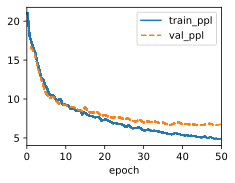

In [22]:
# Default network from example 
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)
# Train time: 1min 44s

In [30]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has the the the the the'

In [53]:
model.predict('we are always', 20, data.vocab, d2l.try_gpu())

'we are alwaysed the time the time'

In [54]:
model.predict('he looked across', 20, data.vocab, d2l.try_gpu())

'he looked across the time the time t'

In [61]:
macs, params = get_model_complexity_info(gru, (1024, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

GRU(
  5.95 k, 100.000% Params, 6.32 MMac, 100.000% MACs, 
  (rnn): GRU(5.95 k, 100.000% Params, 6.32 MMac, 100.000% MACs, 28, 32)
)
Computational complexity:  6.32 MMac
Number of parameters:  5.95 k


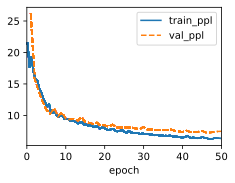

In [56]:
# Halfing the number of hidden states to 16
gru16 = GRU(num_inputs=len(data.vocab), num_hiddens=16)
gruModel16 = d2l.RNNLM(gru16, vocab_size=len(data.vocab), lr=4)
trainer.fit(gruModel16, data)
# Training time: 1min 31sec 

In [57]:
gruModel16.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has mong the the the th'

In [58]:
gruModel16.predict('we are always', 20, data.vocab, d2l.try_gpu())

'we are always the the the the the'

In [59]:
gruModel16.predict('he looked across', 20, data.vocab, d2l.try_gpu())

'he looked acrossing the the the the '

In [64]:
macs, params = get_model_complexity_info(gru16, (1024, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

GRU(
  2.21 k, 100.000% Params, 2.38 MMac, 100.000% MACs, 
  (rnn): GRU(2.21 k, 100.000% Params, 2.38 MMac, 100.000% MACs, 28, 16)
)
Computational complexity:  2.38 MMac
Number of parameters:  2.21 k


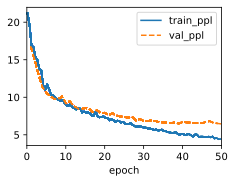

In [60]:
# Increasing the number of hidden states to 48
gru48 = GRU(num_inputs=len(data.vocab), num_hiddens=48)
gruModel48 = d2l.RNNLM(gru48, vocab_size=len(data.vocab), lr=4)
trainer.fit(gruModel48, data)
# Training time: 2mins 14sec

In [32]:
gruModel48.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has interical mentered '

In [61]:
gruModel48.predict('we are always', 20, data.vocab, d2l.try_gpu())

'we are always this space the psyc'

In [62]:
gruModel48.predict('he looked across', 20, data.vocab, d2l.try_gpu())

'he looked across for instance the ti'

In [65]:
macs, params = get_model_complexity_info(gru48, (1024, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

GRU(
  11.23 k, 100.000% Params, 11.85 MMac, 100.000% MACs, 
  (rnn): GRU(11.23 k, 100.000% Params, 11.85 MMac, 100.000% MACs, 28, 48)
)
Computational complexity:  11.85 MMac
Number of parameters:  11.23 k


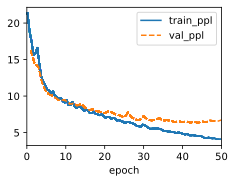

In [63]:
# Increasing the number of hidden states to 64
gru64 = GRU(num_inputs=len(data.vocab), num_hiddens=64)
gruModel64 = d2l.RNNLM(gru64, vocab_size=len(data.vocab), lr=4)
trainer.fit(gruModel64, data)
# Training time: 2min 43sec

In [37]:
gruModel64.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has in thing that that '

In [64]:
gruModel64.predict('we are always', 20, data.vocab, d2l.try_gpu())

'we are always dimension in i sume'

In [65]:
gruModel64.predict('he looked across', 20, data.vocab, d2l.try_gpu())

'he looked across the psychologist yo'

In [66]:
macs, params = get_model_complexity_info(gru64, (1024, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

GRU(
  18.05 k, 100.000% Params, 18.94 MMac, 100.000% MACs, 
  (rnn): GRU(18.05 k, 100.000% Params, 18.94 MMac, 100.000% MACs, 28, 64)
)
Computational complexity:  18.94 MMac
Number of parameters:  18.05 k


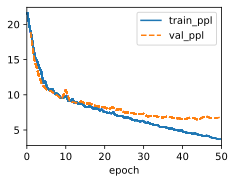

In [66]:
# Increasing the number of hidden states to 128
gru128 = GRU(num_inputs=len(data.vocab), num_hiddens=128)
gruModel128 = d2l.RNNLM(gru128, vocab_size=len(data.vocab), lr=4)
trainer.fit(gruModel128, data)
# Training time: 5min 33sec

In [67]:
gruModel128.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has it and the time tra'

In [68]:
gruModel128.predict('we are always', 20, data.vocab, d2l.try_gpu())

'we are always the time traveller '

In [69]:
gruModel128.predict('he looked across', 20, data.vocab, d2l.try_gpu())

'he looked acrossed the provention is'

In [67]:
macs, params = get_model_complexity_info(gru128, (1024, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

GRU(
  60.67 k, 100.000% Params, 63.05 MMac, 100.000% MACs, 
  (rnn): GRU(60.67 k, 100.000% Params, 63.05 MMac, 100.000% MACs, 28, 128)
)
Computational complexity:  63.05 MMac
Number of parameters:  60.67 k


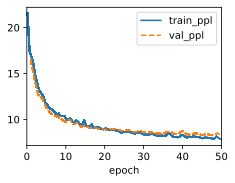

In [71]:
# Decreasing the number of hidden states to 8
gru8 = GRU(num_inputs=len(data.vocab), num_hiddens=8)
gruModel8 = d2l.RNNLM(gru8, vocab_size=len(data.vocab), lr=4)
trainer.fit(gruModel8, data)
# Training time: 1min 29sec

In [72]:
gruModel8.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has the the the the the'

In [73]:
gruModel8.predict('we are always', 20, data.vocab, d2l.try_gpu())

'we are always the the the the the'

In [74]:
gruModel8.predict('he looked across', 20, data.vocab, d2l.try_gpu())

'he looked across the the the the the'

In [68]:
macs, params = get_model_complexity_info(gru8, (1024, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

GRU(
  912, 100.000% Params, 991.23 KMac, 100.000% MACs, 
  (rnn): GRU(912, 100.000% Params, 991.23 KMac, 100.000% MACs, 28, 8)
)
Computational complexity:  991.23 KMac
Number of parameters:  912


# 1b) LSTM

In [23]:
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)


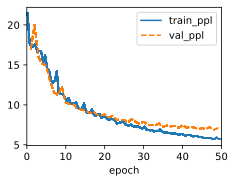

In [44]:
# Default from example
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
lstmModel = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(lstmModel, data)
# Train time: 2min 30sec

In [41]:
lstmModel.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has the traveller and t'

In [45]:
lstmModel.predict('we are always', 20, data.vocab, d2l.try_gpu())

'we are always of the time travell'

In [46]:
lstmModel.predict('he looked across', 20, data.vocab, d2l.try_gpu())

'he looked acrossions and the time tr'

In [71]:
macs, params = get_model_complexity_info(lstm, (1024, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

LSTM(
  7.94 k, 100.000% Params, 8.45 MMac, 100.000% MACs, 
  (rnn): LSTM(7.94 k, 100.000% Params, 8.45 MMac, 100.000% MACs, 28, 32)
)
Computational complexity:  8.45 MMac
Number of parameters:  7.94 k


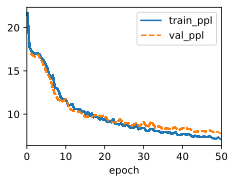

In [25]:
# Halving the number of hidden states to 16
lstm16 = LSTM(num_inputs=len(data.vocab), num_hiddens=16)
LSTMmodel16 = d2l.RNNLM(lstm16, vocab_size=len(data.vocab), lr=4)
trainer.fit(LSTMmodel16, data)
# Training time: 2min 3sec

In [43]:
LSTMmodel16.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has the the the the the'

In [47]:
LSTMmodel16.predict('we are always', 20, data.vocab, d2l.try_gpu())

'we are always of the the the the '

In [48]:
LSTMmodel16.predict('he looked across', 20, data.vocab, d2l.try_gpu())

'he looked across of the the the the '

In [72]:
macs, params = get_model_complexity_info(lstm16, (1024, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

LSTM(
  2.94 k, 100.000% Params, 3.18 MMac, 100.000% MACs, 
  (rnn): LSTM(2.94 k, 100.000% Params, 3.18 MMac, 100.000% MACs, 28, 16)
)
Computational complexity:  3.18 MMac
Number of parameters:  2.94 k


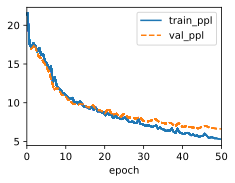

In [26]:
# Increasing the number of hidden states to 48
lstm48 = LSTM(num_inputs=len(data.vocab), num_hiddens=48)
LSTMmodel48 = d2l.RNNLM(lstm48, vocab_size=len(data.vocab), lr=4)
trainer.fit(LSTMmodel48, data)
# Training time: 3min 1sec

In [27]:
LSTMmodel48.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has and the that the th'

In [49]:
LSTMmodel48.predict('we are always', 20, data.vocab, d2l.try_gpu())

'we are always and the that the th'

In [50]:
LSTMmodel48.predict('he looked across', 20, data.vocab, d2l.try_gpu())

'he looked acrossed and the traveller'

In [28]:
macs, params = get_model_complexity_info(lstm48, (1024, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

LSTM(
  14.98 k, 100.000% Params, 15.83 MMac, 100.000% MACs, 
  (rnn): LSTM(14.98 k, 100.000% Params, 15.83 MMac, 100.000% MACs, 28, 48)
)
Computational complexity:  15.83 MMac
Number of parameters:  14.98 k


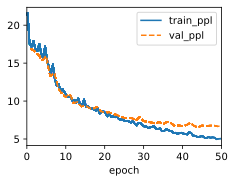

In [29]:
# Increasing the number of hidden states to 64
lstm64 = LSTM(num_inputs=len(data.vocab), num_hiddens=64)
LSTMmodel64 = d2l.RNNLM(lstm64, vocab_size=len(data.vocab), lr=4)
trainer.fit(LSTMmodel64, data)
# Training time: 3min 54sec

In [30]:
LSTMmodel64.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has inour and wather an'

In [51]:
LSTMmodel64.predict('we are always', 20, data.vocab, d2l.try_gpu())

'we are always of and wathereard h'

In [52]:
LSTMmodel64.predict('he looked across', 20, data.vocab, d2l.try_gpu())

'he looked across have and the time t'

In [31]:
macs, params = get_model_complexity_info(lstm64, (1024, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

LSTM(
  24.06 k, 100.000% Params, 25.3 MMac, 100.000% MACs, 
  (rnn): LSTM(24.06 k, 100.000% Params, 25.3 MMac, 100.000% MACs, 28, 64)
)
Computational complexity:  25.3 MMac
Number of parameters:  24.06 k


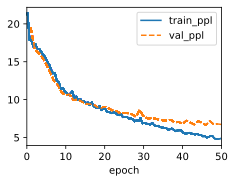

In [32]:
# Increasing the number of hidden states to 128
lstm128 = LSTM(num_inputs=len(data.vocab), num_hiddens=128)
LSTMmodel128 = d2l.RNNLM(lstm128, vocab_size=len(data.vocab), lr=4)
trainer.fit(LSTMmodel128, data)
# Training time: 7min 32sec

In [33]:
LSTMmodel128.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has in and in and the t'

In [36]:
LSTMmodel128.predict('we are always', 20, data.vocab, d2l.try_gpu())

'we are alwayser and the the grome'

In [37]:
LSTMmodel128.predict('he looked across', 20, data.vocab, d2l.try_gpu())

'he looked across of the thing the ti'

In [34]:
macs, params = get_model_complexity_info(lstm128, (1024, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

LSTM(
  80.9 k, 100.000% Params, 84.15 MMac, 100.000% MACs, 
  (rnn): LSTM(80.9 k, 100.000% Params, 84.15 MMac, 100.000% MACs, 28, 128)
)
Computational complexity:  84.15 MMac
Number of parameters:  80.9 k


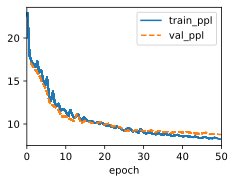

In [38]:
# Decreasing the number of hidden states to 8
lstm8 = LSTM(num_inputs=len(data.vocab), num_hiddens=8)
LSTMmodel8 = d2l.RNNLM(lstm8, vocab_size=len(data.vocab), lr=4)
trainer.fit(LSTMmodel8, data)
# Training time: 2min

In [39]:
LSTMmodel8.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has the the the the the'

In [40]:
LSTMmodel8.predict('we are always', 20, data.vocab, d2l.try_gpu())

'we are always and and and and and'

In [41]:
LSTMmodel8.predict('he looked across', 20, data.vocab, d2l.try_gpu())

'he looked across and and and and and'

In [42]:
macs, params = get_model_complexity_info(lstm8, (1024, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

LSTM(
  1.22 k, 100.000% Params, 1.33 MMac, 100.000% MACs, 
  (rnn): LSTM(1.22 k, 100.000% Params, 1.33 MMac, 100.000% MACs, 28, 8)
)
Computational complexity:  1.33 MMac
Number of parameters:  1.22 k


# RNN Comparison

In [101]:
class RNN(d2l.Module):  
    """The RNN model implemented with high-level APIs."""
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

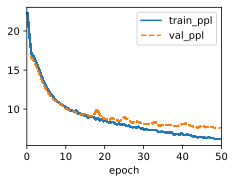

In [102]:
rnn64 = RNN(num_inputs=len(data.vocab), num_hiddens=64)
RNNmodel64 = d2l.RNNLM(rnn64, vocab_size=len(data.vocab), lr=1)
trainer.fit(RNNmodel64, data)
# Training time: 2min 11sec

In [103]:
RNNmodel64.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has and hin the proun t'

In [105]:
RNNmodel64.predict('we are always', 20, data.vocab, d2l.try_gpu())

'we are always all has in the time'

In [106]:
RNNmodel64.predict('he looked across', 20, data.vocab, d2l.try_gpu())

'he looked across his said the time t'

In [107]:
macs, params = get_model_complexity_info(rnn64, (1024, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

RNN(
  6.02 k, 100.000% Params, 6.23 MMac, 100.000% MACs, 
  (rnn): RNN(6.02 k, 100.000% Params, 6.23 MMac, 100.000% MACs, 28, 64)
)
Computational complexity:  6.23 MMac
Number of parameters:  6.02 k


# 2a) Deep GRU

In [75]:
class deepGRU(d2l.RNN):
    """The multi-layer GRU model."""
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0.5):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, num_layers,
                          dropout=dropout)

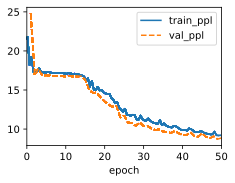

In [76]:
# GRU w/ 3 layers
deepGru3 = deepGRU(num_inputs=len(data.vocab), num_hiddens=32, num_layers=3)
deepGRUModel3 = d2l.RNNLM(deepGru3, vocab_size=len(data.vocab), lr=2)
trainer.fit(deepGRUModel3, data)
# Train time: 3min 14sec 

In [62]:
macs, params = get_model_complexity_info(deepGru3, (1024, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

deepGRU(
  18.62 k, 100.000% Params, 19.76 MMac, 100.000% MACs, 
  (rnn): GRU(18.62 k, 100.000% Params, 19.76 MMac, 100.000% MACs, 28, 32, num_layers=3, dropout=0.5)
)
Computational complexity:  19.76 MMac
Number of parameters:  18.62 k


In [77]:
deepGRUModel3.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has the the the the the'

In [78]:
deepGRUModel3.predict('we are always', 20, data.vocab, d2l.try_gpu())

'we are always the the the the the'

In [79]:
deepGRUModel3.predict('he looked across', 20, data.vocab, d2l.try_gpu())

'he looked across the the the the the'

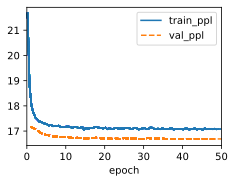

In [80]:
# GRU w/ 5 layers
deepGru5 = deepGRU(num_inputs=len(data.vocab), num_hiddens=32, num_layers=5)
deepGRUModel5 = d2l.RNNLM(deepGru5, vocab_size=len(data.vocab), lr=2)
trainer.fit(deepGRUModel5, data)
# Train time: 5min 30sec

In [81]:
macs, params = get_model_complexity_info(deepGru5, (1024, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

deepGRU(
  31.3 k, 100.000% Params, 33.19 MMac, 100.000% MACs, 
  (rnn): GRU(31.3 k, 100.000% Params, 33.19 MMac, 100.000% MACs, 28, 32, num_layers=5, dropout=0.5)
)
Computational complexity:  33.19 MMac
Number of parameters:  31.3 k


In [84]:
deepGRUModel5.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has                    '

In [83]:
deepGRUModel5.predict('we are always', 20, data.vocab, d2l.try_gpu())

'we are always                    '

In [85]:
deepGRUModel5.predict('he looked across', 20, data.vocab, d2l.try_gpu())

'he looked across                    '

# 2b) Deep LSTM

In [93]:
class deepLSTM(d2l.RNN):
    """The multi-layer LSTM model."""
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0.5):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens, num_layers,
                          dropout=dropout)

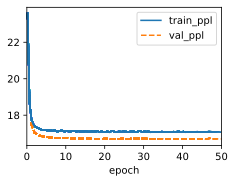

In [88]:
# LSTM w/ 3 layers
deepLSTM3 = deepLSTM(num_inputs=len(data.vocab), num_hiddens=32, num_layers=3)
deepLSTMModel3 = d2l.RNNLM(deepLSTM3, vocab_size=len(data.vocab), lr=2)
trainer.fit(deepLSTMModel3, data)
# Train time: 4min 33sec

In [76]:
macs, params = get_model_complexity_info(deepLSTM3, (1024, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

deepLSTM(
  24.83 k, 100.000% Params, 26.41 MMac, 100.000% MACs, 
  (rnn): LSTM(24.83 k, 100.000% Params, 26.41 MMac, 100.000% MACs, 28, 32, num_layers=3, dropout=0.5)
)
Computational complexity:  26.41 MMac
Number of parameters:  24.83 k


In [89]:
deepLSTMModel3.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has                    '

In [90]:
deepLSTMModel3.predict('we are always', 20, data.vocab, d2l.try_gpu())

'we are always                    '

In [91]:
deepLSTMModel3.predict('he looked across', 20, data.vocab, d2l.try_gpu())

'he looked across                    '

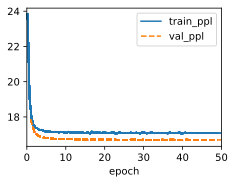

In [94]:
# LSTM w/ 5 layers
deepLSTM5 = deepLSTM(num_inputs=len(data.vocab), num_hiddens=32, num_layers=5)
deepLSTMModel5 = d2l.RNNLM(deepLSTM5, vocab_size=len(data.vocab), lr=2)
trainer.fit(deepLSTMModel5, data)
# Train time: 6min 37sec

In [95]:
macs, params = get_model_complexity_info(deepLSTM5, (1024, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

deepLSTM(
  41.73 k, 100.000% Params, 44.37 MMac, 100.000% MACs, 
  (rnn): LSTM(41.73 k, 100.000% Params, 44.37 MMac, 100.000% MACs, 28, 32, num_layers=5, dropout=0.5)
)
Computational complexity:  44.37 MMac
Number of parameters:  41.73 k


In [96]:
deepLSTMModel5.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has                    '

In [97]:
deepLSTMModel5.predict('we are always', 20, data.vocab, d2l.try_gpu())

'we are always                    '

In [98]:
deepLSTMModel5.predict('he looked across', 20, data.vocab, d2l.try_gpu())

'he looked across                    '